In [ ]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In [36]:
start_date = '2000-01-01'
end_date = '2024-12-31'

sp500_daily_query = f"""
SELECT
    s.permno, 
    s.date, 
    s.ret, 
    s.prc AS close,
    s.shrout AS shares_outstanding, -- This line was added
    s.vol, 
    s.openprc AS open, 
    s.askhi AS high, 
    s.bidlo AS low, 
    s.cfacpr 
FROM
    crsp.dsf AS s
INNER JOIN
    crsp.msp500list AS m ON s.permno = m.permno
WHERE
    s.date BETWEEN m.start AND m.ending
    AND s.date BETWEEN '{start_date}' AND '{end_date}'
ORDER BY
    s.permno, 
    s.date;
"""

sp500_daily_data = db.raw_sql(sp500_daily_query)
sp500_daily_data['date'] = pd.to_datetime(sp500_daily_data['date'])

sp500_daily_data

,permno,date,ret,close,shares_outstanding,vol,open,high,low,cfacpr
0,10078,2000-01-03,-0.012107,76.5,1561106.0,15270527.0,79.25,79.375,74.5,0.5
1,10078,2000-01-04,-0.062092,71.75,1561106.0,21098710.0,73.4375,75.25,71.5,0.5
2,10078,2000-01-05,0.001742,71.875,1561106.0,30073258.0,70.125,73.5,66.625,0.5
3,10078,2000-01-06,-0.053913,68.0,1561106.0,22741999.0,70.4375,71.875,67.0,0.5
4,10078,2000-01-07,0.056985,71.875,1561106.0,20450260.0,67.1875,72.0,66.75,0.5
...,...,...,...,...,...,...,...,...,...,...
155298,93436,2024-12-24,0.073572,462.28,3210060.0,59351506.0,435.89999,462.78,435.14001,1.0
155299,93436,2024-12-26,-0.01763,454.13,3210060.0,76392273.0,465.16,465.3299,451.01999,1.0
155300,93436,2024-12-27,-0.049479,431.66,3210060.0,82370345.0,449.51999,450.0,426.5,1.0
155301,93436,2024-12-30,-0.033012,417.41,3210060.0,64705452.0,419.39999,427.0,415.75,1.0


In [37]:
missing_values = sp500_daily_data.isnull().sum()
print(missing_values)

permno                   0
date                     0
ret                    106
close                   11
shares_outstanding       0
vol                     15
open                  4980
high                    11
low                     11
cfacpr                   0
dtype: int64


In [3]:
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [38]:
unique_permnos = tuple(sp500_daily_data['permno'].unique())

gics_query = f"""
    SELECT 
        b.lpermno AS permno, a.gsector
    FROM 
        comp.company AS a
    JOIN 
        crsp.ccmxpf_linktable AS b ON a.gvkey = b.gvkey
    WHERE 
        b.linktype IN ('LU', 'LC')
        AND b.linkprim IN ('P', 'C')
        AND b.lpermno IN {unique_permnos}
"""

gics_data = db.raw_sql(gics_query)

gics_sectors = {
    10: 'Energy', 15: 'Materials', 20: 'Industrials', 25: 'Consumer Discretionary',
    30: 'Consumer Staples', 35: 'Health Care', 40: 'Financials',
    45: 'Information Technology', 50: 'Communication Services', 55: 'Utilities',
    60: 'Real Estate'
}

gics_data['gsector'] = pd.to_numeric(gics_data['gsector'], errors='coerce')
gics_data['gsector_name'] = gics_data['gsector'].map(gics_sectors)

sp500_daily_data['permno'] = pd.to_numeric(sp500_daily_data['permno'], errors='coerce').astype('Int64')
gics_data['permno'] = pd.to_numeric(gics_data['permno'], errors='coerce').astype('Int64')

gics_map = gics_data.dropna(subset=['permno', 'gsector_name']).drop_duplicates(subset='permno', keep='last')

sp500_daily_data = sp500_daily_data.merge(gics_map[['permno', 'gsector_name']], on='permno', how='left')
sp500_daily_data['gsector_name'] = sp500_daily_data['gsector_name'].fillna('Unknown')

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_88347/3258151607.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


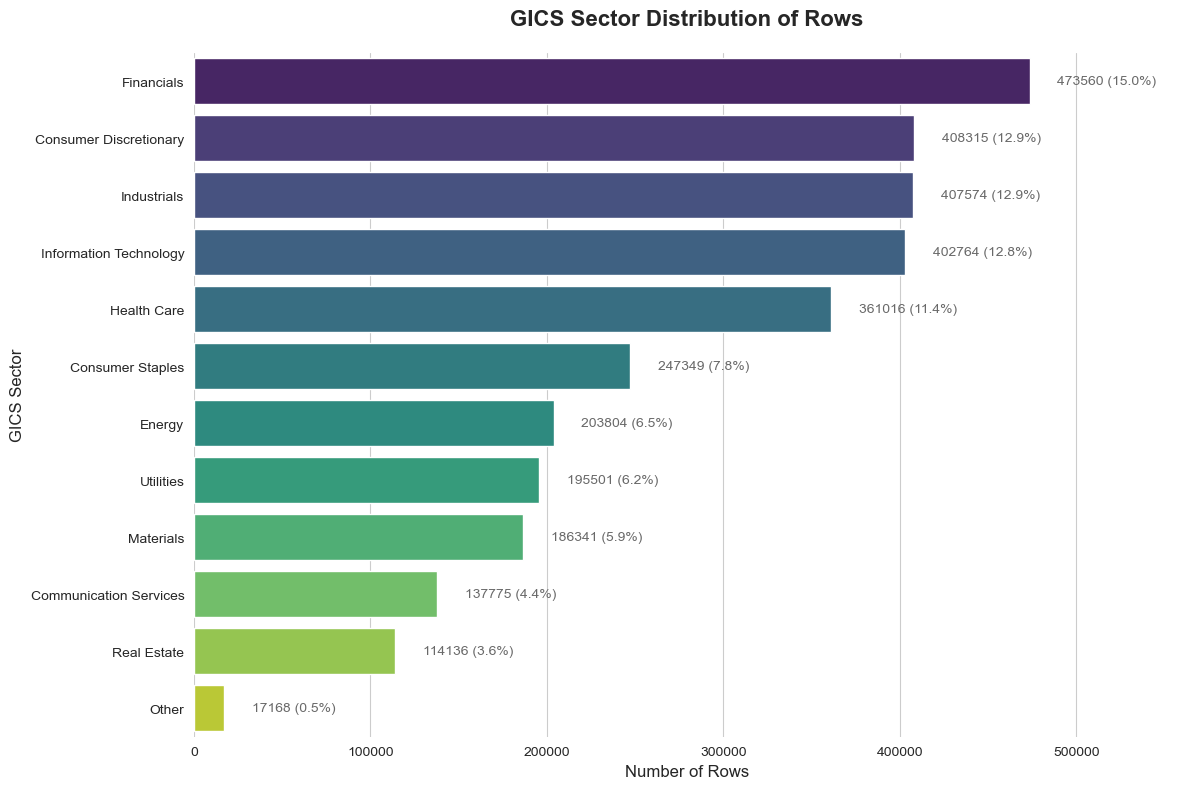

In [ ]:
sector_counts = sp500_daily_data['gsector_name'].fillna('Unknown').value_counts()
total = sector_counts.sum()
small_pct = 0.03
large = sector_counts[sector_counts / total >= small_pct]
small = sector_counts[sector_counts / total < small_pct]

if len(small) > 0:
    sector_counts_plot = pd.concat([large, pd.Series({'Other': small.sum()})])
else:
    sector_counts_plot = large

sector_counts_plot = sector_counts_plot.sort_values(ascending=False)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

palette = sns.color_palette('viridis', n_colors=len(sector_counts_plot))
barplot = sns.barplot(
    y=sector_counts_plot.index,
    x=sector_counts_plot.values,
    palette=palette,
    ax=ax
)

for i, (count, pct) in enumerate(zip(sector_counts_plot.values, sector_counts_plot.values / total)):
    ax.text(
        count + total * 0.005,  # Position text slightly to the right of the bar
        i,                      # Y-coordinate of the bar's center
        f'{count} ({pct:.1%})',   # Text to display (e.g., "4194 (28.0%)")
        va='center',            # Vertically align to the center
        fontsize=10,
        color='dimgray'
    )

ax.set_title('GICS Sector Distribution of Rows', fontsize=16, weight='bold', pad=20)
ax.set_xlabel('Number of Rows', fontsize=12)
ax.set_ylabel('GICS Sector', fontsize=12)

ax.set_xlim(0, sector_counts_plot.max() * 1.18)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [ ]:
sp500_daily_data['mktcap'] = sp500_daily_data['close'] * sp500_daily_data['shares_outstanding']
# we convert it in billions
sp500_daily_data['mktcap'] = sp500_daily_data['mktcap'] / 1e6   
sp500_daily_data

,permno,date,ret,close,shares_outstanding,vol,open,high,low,cfacpr,gsector_name,mktcap
0,10078,2000-01-03,-0.012107,76.5,1561106.0,15270527.0,79.25,79.375,74.5,0.5,Information Technology,119.424609
1,10078,2000-01-04,-0.062092,71.75,1561106.0,21098710.0,73.4375,75.25,71.5,0.5,Information Technology,112.009355
2,10078,2000-01-05,0.001742,71.875,1561106.0,30073258.0,70.125,73.5,66.625,0.5,Information Technology,112.204494
3,10078,2000-01-06,-0.053913,68.0,1561106.0,22741999.0,70.4375,71.875,67.0,0.5,Information Technology,106.155208
4,10078,2000-01-07,0.056985,71.875,1561106.0,20450260.0,67.1875,72.0,66.75,0.5,Information Technology,112.204494
...,...,...,...,...,...,...,...,...,...,...,...,...
3155298,93436,2024-12-24,0.073572,462.28,3210060.0,59351506.0,435.89999,462.78,435.14001,1.0,Consumer Discretionary,1483.946537
3155299,93436,2024-12-26,-0.01763,454.13,3210060.0,76392273.0,465.16,465.3299,451.01999,1.0,Consumer Discretionary,1457.784548
3155300,93436,2024-12-27,-0.049479,431.66,3210060.0,82370345.0,449.51999,450.0,426.5,1.0,Consumer Discretionary,1385.6545
3155301,93436,2024-12-30,-0.033012,417.41,3210060.0,64705452.0,419.39999,427.0,415.75,1.0,Consumer Discretionary,1339.911145


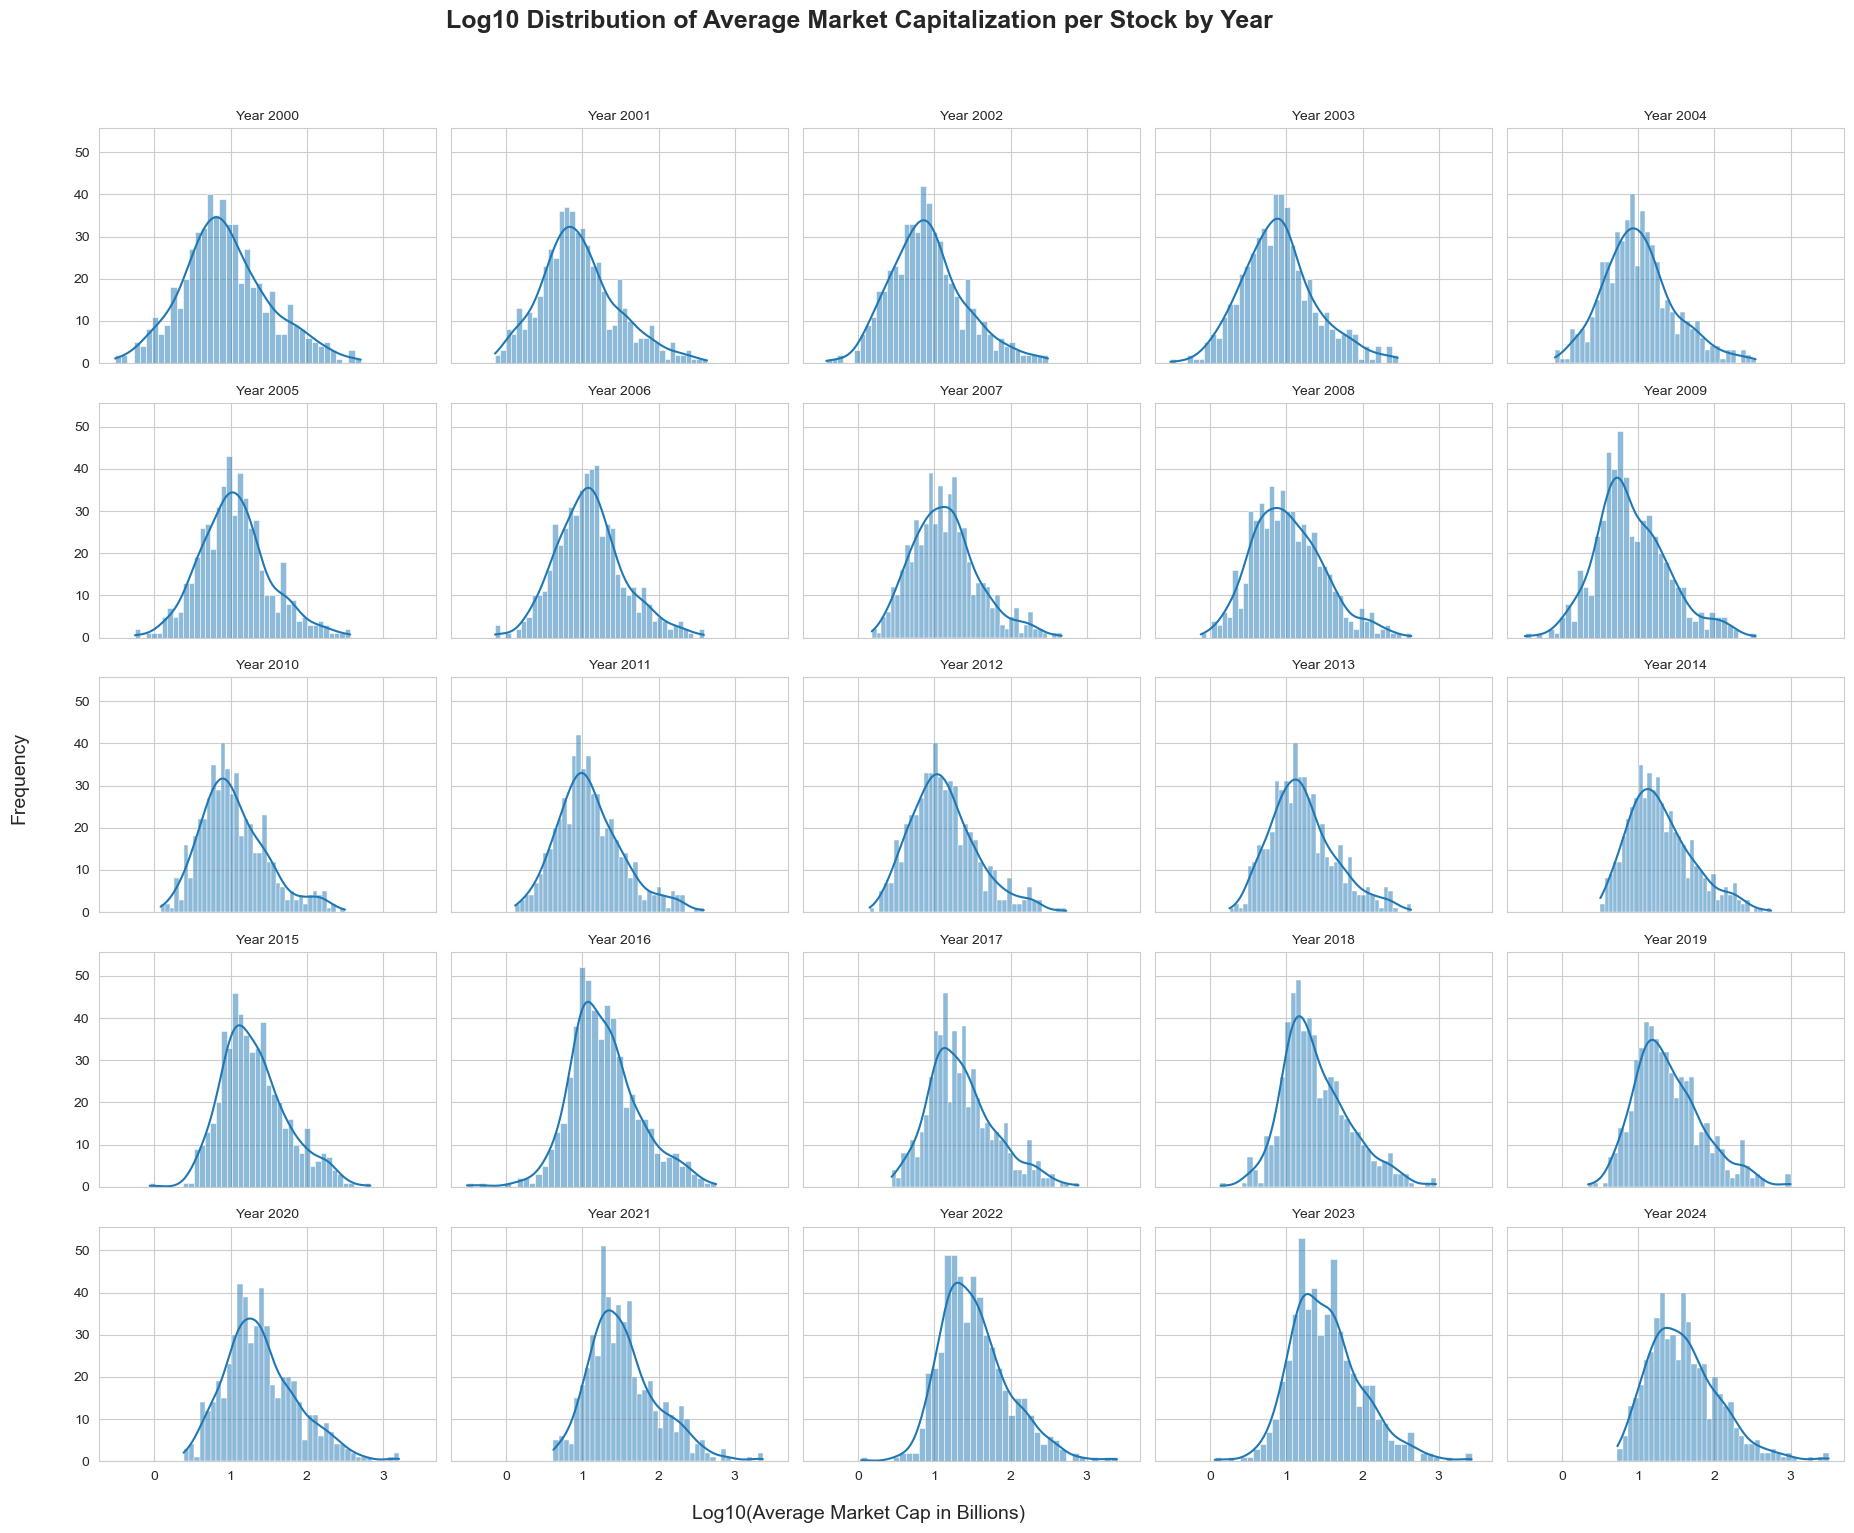

In [ ]:
sp500_daily_data['year'] = sp500_daily_data['date'].dt.year

years = sorted(sp500_daily_data['year'].unique())

n_years = len(years)
n_cols = 5
n_rows = (n_years + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16), sharex=True, sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    
    year_data = sp500_daily_data[sp500_daily_data['year'] == year]
    
    avg_mktcap_per_permno = year_data.groupby('permno')['mktcap'].mean()
    
    avg_mktcap_per_permno = avg_mktcap_per_permno[avg_mktcap_per_permno > 0]
    
    if not avg_mktcap_per_permno.empty:
        sns.histplot(np.log10(avg_mktcap_per_permno), bins=40, ax=ax, kde=True)
    
    ax.set_title(f'Year {year}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(n_years, len(axes)):
    axes[i].set_visible(False)

fig.suptitle('Log10 Distribution of Average Market Capitalization per Stock by Year', fontsize=18, weight='bold')
fig.text(0.5, 0.04, 'Log10(Average Market Cap in Billions)', ha='center', va='center', fontsize=14)
fig.text(0.08, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.1, 0.05, 1, 0.95])
plt.show()

/var/folders/sb/pr5trk8n2y152hph287lsny00000gn/T/ipykernel_88347/1009041352.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.06, 1, 0.96])


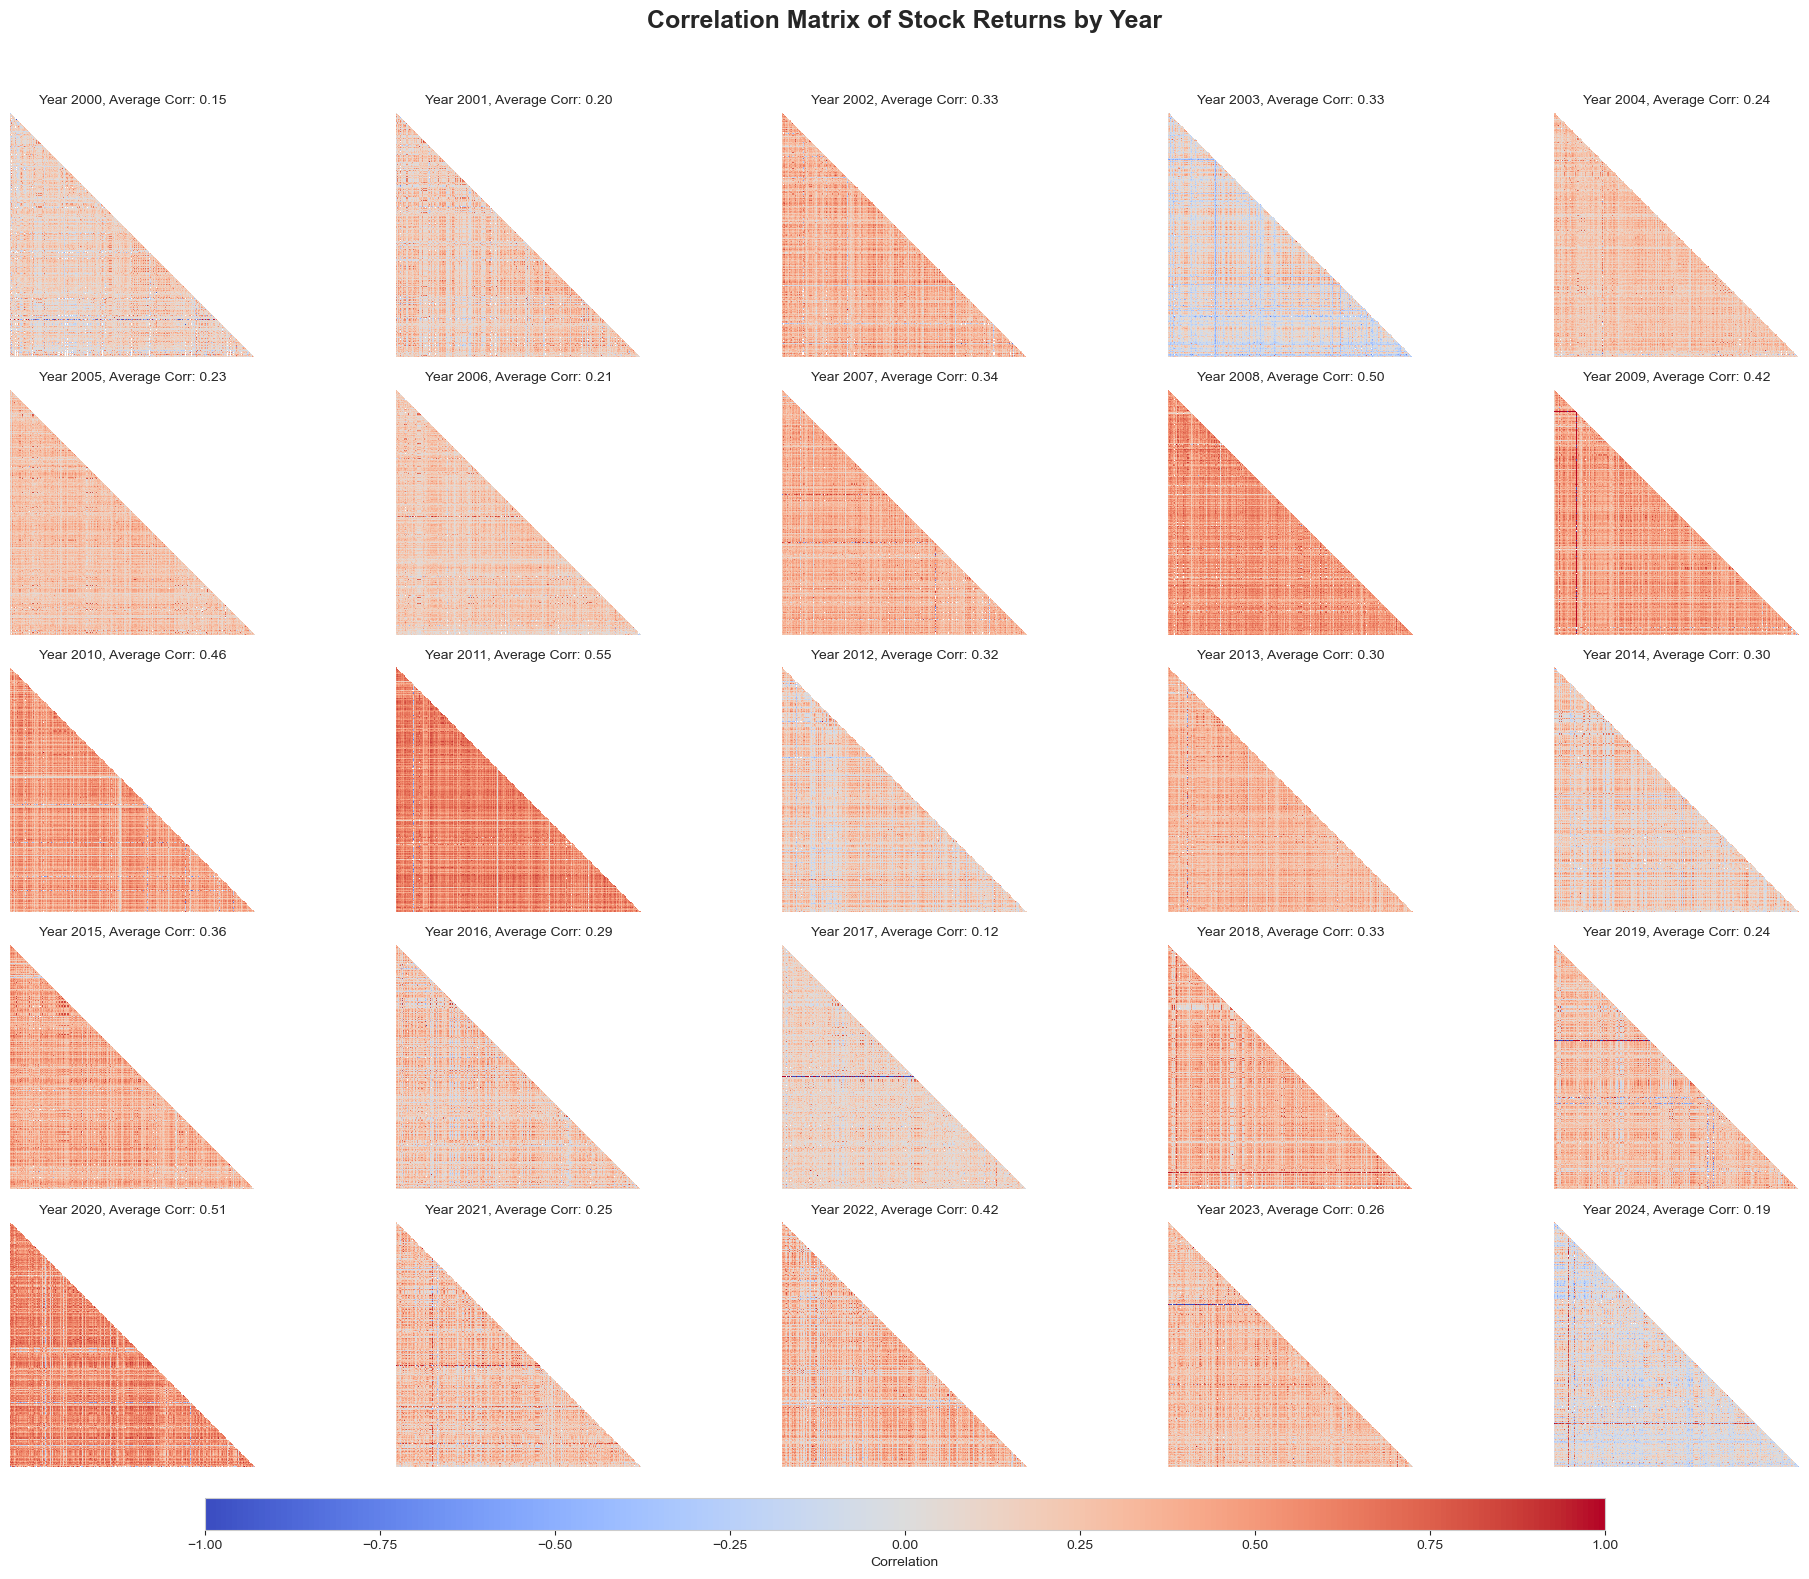

In [ ]:
sp500_daily_data['year'] = sp500_daily_data['date'].dt.year
years = sorted(sp500_daily_data['year'].unique())

n_years = len(years)
n_cols = 5
n_rows = (n_years + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    
    data_for_year = sp500_daily_data[sp500_daily_data['year'] == year]
    
    returns_pivot = data_for_year.pivot(index='date', columns='permno', values='ret').dropna(axis=1, how='all')

    returns_pivot = returns_pivot.loc[:, returns_pivot.nunique(dropna=True) > 1]

    if returns_pivot.shape[1] > 1:
        correlation_matrix = returns_pivot.corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=False, square=True,
                    ax=ax, cbar=False)

        triu_vals = correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)]
        valid = triu_vals[np.isfinite(triu_vals)]
        avg_corr = valid.mean() if valid.size > 0 else np.nan
    else:
        correlation_matrix = pd.DataFrame()
        avg_corr = np.nan

    title = f'Year {year}, Average Corr: {avg_corr:.2f}' if not np.isnan(avg_corr) else f'Year {year}, Average Corr: n/a'
    ax.set_title(title, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(n_years, len(axes)):
    axes[i].set_visible(False)

cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1, vmax=1), cmap='coolwarm')
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Correlation')

fig.suptitle('Correlation Matrix of Stock Returns by Year', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.06, 1, 0.96])

plt.show()
